## Imports

In [1]:
import numpy as np 
import pandas as pd
import regex as re
import unicodedata as ud
import nltk
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import wordpunct_tokenize
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
import multiprocessing
from tqdm import tqdm
from sklearn import utils
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import numpy as np
import arabic_reshaper as ar
from bidi.algorithm import get_display
import matplotlib.pyplot as plt

## Movies Datasets

In [2]:
forties_df = pd.read_csv('1940s_data/1940s_movies.csv')
fifties_df = pd.read_csv('1950s_data/1950s_movies.csv')
sixties_df = pd.read_csv('1960s_data/1960s_movies.csv')
seventies_df = pd.read_csv('1970s_data/1970s_movies.csv')

#### EDA functions

In [3]:
def describe_dataframe(df):
    
    for column in df.columns:
        
        print('Column Name: ', u'\u202B' + str(column) + u'\u202C')
        print(df[column].describe())
        print('\n'+'-'*20)

#### Cleansing functions

In [4]:
def change_empty_entries_to_None(df):
    for column in df.columns:
        for row_index in range(df.shape[0]):
            if '??' in str(df.loc[row_index, column]) or \
            df.loc[row_index, column] == 'nan' or \
            df.loc[row_index, column] == '-' or \
            type(df.loc[row_index, column]) == float:
                    df.loc[row_index, column] = None
    return df

In [5]:
def unify_date_format(df):
    for row in range(df.shape[0]):
        
        release_day = df.iloc[row, 15]
        if len(str(release_day)) == 4:
            df.iloc[row,17] = release_day
            df.iloc[row,16] = 'يناير'

    return df

In [6]:
def expand_release_date(df):
    # line continuation operators  '\' used for cleaner code
    df[['اليوم', 'الشهر', 'السنة']] = \
    df['تاريخ العرض'].str.split(' ', expand = True)
    
    return df

In [7]:
def parse_line(line_to_parse):
    
            parsed_values = line_to_parse.split('||')
            movie_name_date = parsed_values[0].strip(')').split('(')
            
            name = movie_name_date[0]
            year = movie_name_date[1]
            df_feature = parsed_values[1]
            
            return name, year, df_feature

In [8]:
def add_scraped_features(df, file_path, column_name):
    
    with open(file_path, 'r') as filehandle:
        
        for line in filehandle:
            
            current_line = line[:-1]
            name, year, df_feature = parse_line(current_line)
            if(not(df_feature == '') \
              or (str(df_feature) == 'nan')):
                df.loc[(df['اسم الفيلم'] == name) \
                     & (df['السنة'] == year), column_name] = df_feature     
    return df

In [9]:
def filter_foregin_movies(df, file_path):
    
    with open(file_path, 'r') as filehandle:
            
        for line in filehandle:
            
            current_line = line[:-1]
            name, year, country = parse_line(current_line)
           
            if(not(('مصر') in country)):   
                movie_index = df.loc[(df['اسم الفيلم'] == name) \
                                     & (df['السنة'] == year)].index
                df.drop(inplace = True, index = movie_index)
    return df

In [287]:
def fix_genre_labels(df):
    for row_index in range(df.shape[0]):
        genre = df.loc[row_index, 'التصنيف']
        if(genre == 'خيال علمي'):
            print('here!')
            df.loc[row_index, 'التصنيف'] = 'خيال'
    return df

In [11]:
def get_null_percentage(df):
    
    total_count = df.shape[0]
    for column in df.columns:
    
        missing_count = df[column].isna().sum()
        missing_percentage = (missing_count/total_count)*100
        print('>> ' + u'\u202B' + column + ': '+ str(round(missing_percentage)) + '%')

In [12]:
actor_gender_dictionary = pd.read_csv('actor_gender_dictionary.csv')

In [13]:
actor_gender_dictionary.sample()

,Unnamed: 0,name,gender
2241,1098,روبرت ويبر,ذكر


In [14]:
actor_gender_dictionary.drop(columns = ['Unnamed: 0'], inplace= True)

In [15]:
actor_gender_dictionary.sample()

,name,gender
2199,أوجا أبو الذهب,ذكر


In [16]:
def seperate_cast_by_gender(movies_df, gender_df = actor_gender_dictionary):
    
    movies_df['ممثلات'] = None
    movies_df['ممثلون'] = None
    
    for row_index in range(movies_df.shape[0]):
        
        cast = movies_df.loc[row_index, 'تمثيل']
        try:
            actresses = []
            actors = []
            if( ',' in cast):
                
                cast = cast.split(',')
    
                for actor in cast:
             
                    gender = gender_df.loc[gender_df['name'] == actor]['gender']

                    if(gender.values == 'ذكر'):
                        actors.append(actor)
                        
                    if(gender.values == 'أنثى'):
                        actresses.append(actor)
                        
                movies_df.at[row_index, 'ممثلات'] = actresses
                movies_df.at[row_index, 'ممثلون'] = actors
                        
        except:
                'Unassigned: ' + str(actor) + ' in row: ' + str(row_index)
                
        finally:
                movies_df.at[row_index, 'ممثلات'] = actresses
                movies_df.at[row_index, 'ممثلون'] = actors
    return movies_df  

In [17]:
def split_string(string_to_split):
    crew_names = []
    try:
        for word in string_to_split.split(','):
            crew_names.append(word)
    except:
        print('No crew information available')
    finally:
        return crew_names

In [18]:
def seperate_authors_directors(movies_df):
    for row_index in range(movies_df.shape[0]):
        authors = movies_df.loc[row_index, 'تأليف']
        directors = movies_df.loc[row_index, 'إخراج']
        
        authors_list = split_string(authors)
        directors_list = split_string(directors)
        
        movies_df.at[row_index, 'تأليف'] = authors_list
        movies_df.at[row_index, 'إخراج'] = directors_list
    return movies_df

### *_1940s Movies_*

#### EDA

In [19]:
describe_dataframe(forties_df)

Column Name:  ‫اسم الفيلم‬
count             331
unique            330
top       خاتم سليمان
freq                2
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫تاريخ العرض‬
count      331
unique     216
top       1946
freq        24
Name: تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       127
unique        9
top       ??ا??
freq         46
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count    331.000000
mean     106.399698
std       11.097976
min       70.000000
25%      100.000000
50%      105.000000
75%      110.000000
max      152.000000
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count                                                   316
unique                                                  316
top       وحيدة فتاة بسيطة تربت فى منزل جليله هانم التى ...
freq                                                      1
Name: ملخص, dtype: object

--------------------
Column N

In [20]:
forties_df.loc[forties_df['اسم الفيلم'] == 'خاتم سليمان']

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
174,خاتم سليمان,1946,NaN,103.2,NaN,أبو بثينة,أمينة شريف,أفلام حرب,NaN,NaN,NaN,NaN,NaN,فؤاد شبل,NaN
227,خاتم سليمان,1947,ا????ا??,117.0,تناول الفيلم في إطار من الخيال، قصة المعلم بيو...,"حسن رمزي,السيد زيادة","ليلى مراد,يحيى شاهين,زكي رستم,نيللي مظلوم,ثريا...",أفلام النصر (محمد حسن رمزي وشركاه),"مصطفى حسن,وحيد فريد","ألبير نجيب,وفيقة أبو جبل",حبيب خوري,قاسم وجدي,"حسين السيد,السيد زيادة,رياض السنباطي,محمد القص...","حسن رمزي,ألبير نجيب,عبدالرحمن شريف",NaN


In [21]:
forties_df.dtypes

اسم الفيلم      object
تاريخ العرض     object
التصنيف         object
المدة          float64
ملخص            object
تأليف           object
تمثيل           object
إنتاج           object
تصوير           object
مونتاج          object
ديكور           object
ملابس           object
موسيقى          object
إخراج           object
توزيع           object
dtype: object

In [22]:
forties_df['التصنيف'].value_counts()

??ا??       46
???????     26
??????      25
ا????ا??    16
?????        7
????         2
?????ا?      2
تاريخي       2
???          1
Name: التصنيف, dtype: int64

In [23]:
get_null_percentage(forties_df)

>> ‫اسم الفيلم: 0%
>> ‫تاريخ العرض: 0%
>> ‫التصنيف: 62%
>> ‫المدة: 0%
>> ‫ملخص: 5%
>> ‫تأليف: 7%
>> ‫تمثيل: 1%
>> ‫إنتاج: 26%
>> ‫تصوير: 15%
>> ‫مونتاج: 28%
>> ‫ديكور: 39%
>> ‫ملابس: 94%
>> ‫موسيقى: 35%
>> ‫إخراج: 6%
>> ‫توزيع: 49%


#### Cleansing

In [24]:
forties_df = change_empty_entries_to_None(forties_df)

In [25]:
forties_df['التصنيف'].value_counts()

تاريخي    2
Name: التصنيف, dtype: int64

In [26]:
expanded_date_40s = forties_df.copy(deep = True)

In [27]:
expanded_date_40s = expand_release_date(forties_df)
expanded_date_40s = unify_date_format(expanded_date_40s)

In [28]:
expanded_date_40s = expanded_date_40s.drop(columns=['تاريخ العرض','اليوم'])
expanded_date_40s['التقييم'] = None

_**Filling Missing Values**_

* **Add Webscraped Ratings**

In [29]:
foreigns_filtered_40s  = expanded_date_40s.copy(deep = True)

In [30]:
foreigns_filtered_40s = filter_foregin_movies(expanded_date_40s \
                                                , '1940s_data/countries_1940s.txt')

In [31]:
genre_added_40s = foreigns_filtered_40s.copy(deep = True)

In [32]:
genre_added_40s = add_scraped_features(foreigns_filtered_40s \
                                          , '1940s_data/1940s_genres.txt' \
                                         , 'التصنيف')

In [33]:
genre_added_40s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                75
ﻛﻮﻣﻴﺪﻱ               23
موسيقي / استعراضي    13
ﺭﻭﻣﺎﻧﺴﻲ              12
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          2
ﺟﺮﻳﻤﺔ                 2
ﻋﺎﺋﻠﻲ                 2
ﺣﺮﺏ                   1
ﻣﻐﺎﻣﺮاﺕ               1
ﺧﻴﺎﻝ                  1
Name: التصنيف, dtype: int64

In [34]:
ratings_added_40s = genre_added_40s.copy(deep = True)

In [35]:
ratings_added_40s = add_scraped_features(genre_added_40s \
                                          , '1940s_data/1940s_ratings.txt' \
                                         , 'التقييم')

In [36]:
synopsis_added_40s = ratings_added_40s.copy(deep = True)

In [37]:
synopsis_added_40s = add_scraped_features(ratings_added_40s \
                                          , '1940s_data/1940s_synopses.txt' \
                                         , 'ملخص')

In [38]:
synopsis_added_40s = synopsis_added_40s.reset_index(drop=True)

In [39]:
synopsis_added_40s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
236,هارب من السجن,None,95.0,يعلن الثري عزيز إفلاسه، يتشاجر مع أحد الأشخاص ...,محمد عبدالجواد,"حسين رياض,أمينة رزق,سراج منير,عبدالوارث عسر,فا...","اتحاد الفنيين,ستوديوهات (حدائق) شبرا","امبرتو لانزانو,جوليو دى لوكا",إحسان فرغل,"شدياق,محلات طمان",None,"عبدالعزيز محمود,محمد صلاح الدين","محمد عبدالجواد,محمود فريد,حسن نعمة الله,جورجيت...",نحّاس فيلم,فبراير,1948,5.4


In [40]:
get_null_percentage(synopsis_added_40s)

>> ‫اسم الفيلم: 0%
>> ‫التصنيف: 60%
>> ‫المدة: 0%
>> ‫ملخص: 2%
>> ‫تأليف: 7%
>> ‫تمثيل: 1%
>> ‫إنتاج: 26%
>> ‫تصوير: 14%
>> ‫مونتاج: 28%
>> ‫ديكور: 39%
>> ‫ملابس: 94%
>> ‫موسيقى: 35%
>> ‫إخراج: 6%
>> ‫توزيع: 48%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التقييم: 5%


In [41]:
synopsis_added_40s['التقييم'] = synopsis_added_40s['التقييم'].astype(float)

In [42]:
cast_seperated_40s = seperate_cast_by_gender(synopsis_added_40s)

/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [43]:
cast_seperated_40s.drop(inplace = True, columns = ['تمثيل'])

In [44]:
cast_seperated_40s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم,ممثلات,ممثلون
233,عدل السماء,None,100.0,يوضع موظف مستقيم في موقف لا يحسد عليه حين يتهم...,"أحمد شكري,أحمد كامل مرسي",اتحاد الفنانين للسينما والفيديو,None,أحمد إسماعيل,"سيد شاهين,عبدالفتاح فريد",None,"مختارات موسيقية,عبدالعزيز سلام","أحمد كامل مرسي,عاطف سالم",منتخبات بهنا فيلم,يناير,1948,7.0,"[فردوس حسن, شادية, عزيزة حلمي, ميمي عزيز]","[حسين رياض, محمود المليجي, كمال الشناوي, عبدال..."


In [45]:
cast_seperated_40s.drop(columns = ['توزيع', 'ملابس', 'ديكور', 'مونتاج', \
                         'تصوير', 'موسيقى', 'إنتاج'], inplace = True)

In [46]:
movies_40s_df = cast_seperated_40s[['اسم الفيلم', 'الشهر', 'السنة', 'التصنيف',\
                                    'التقييم', 'المدة', 'ملخص', 'ممثلات', 'ممثلون',
                                    'تأليف', 'إخراج']]

In [47]:
movies_40s_df.sample()

,اسم الفيلم,الشهر,السنة,التصنيف,التقييم,المدة,ملخص,ممثلات,ممثلون,تأليف,إخراج
56,جوهرة,يناير,1943,ﺩﺭاﻣﺎ,6.2,138.0,أصبح سمير من أشهر ملحني ومؤلفي الموسيقى محاولً...,"[نور الهدى, زوزو شكيب, سميرة كمال, أمينة محمد,...","[يوسف وهبي, فؤاد شفيق, حسن فايق, فاخر فاخر, مح...",يوسف وهبي,يوسف وهبي


### *_1950s Movies_*

_**EDA**_

In [48]:
fifties_df.sample(10)

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
308,أحلام الربيع,23 مايو 1955,NaN,95.0,فتاة شهدت أمها تموت وهى تضع طفلتها الثانية، فت...,"السيد زيادة,حسن رمزي,برلنتى العشرى","كمال الشناوي,مديحة يسري,فردوس محمد,ثريا حلمي,ث...",عبدالمقصود فرجاني,"ضياء الدين المهدي,برونو سالفي",كمال أبو العلا,"عباس حلمي,ستوديو الأهرام (ستوديوهات الأهرام),ح...",NaN,اسطوانات,"حسن رمزي,أحمد فاروق",NaN
378,هل أقتل زوجى,1956,NaN,108.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,فايق ورايق,29 نوفمبر 1951,NaN,97.0,يطلق المطرب رايق زوجته الراقصة أشواق لثالث مرة...,"حلمي رفلة,أبو السعود الإبياري","تحية كاريوكا,كارم محمود,إسماعيل يس,سميحة توفيق...",أفلام حلمى رفلة,"ضياء الدين المهدي,برونو سالفي,سمير حلمي",سعيد الشيخ,عباس حلمي,NaN,أبو السعود الإبياري,"حلمي رفلة,عاطف سالم",منتخبات بهنا فيلم
136,السماء لا تنام,27 اكتوبر 1952,??ا??,111.1,جمال مهندس شاب يعمل عند شكري بك المقاول الثري ...,صالح جودت,"لولا صدقي,صلاح منصور,عباس فارس,جمال فارس,مريم ...",NaN,محمود نصر,NaN,NaN,NaN,NaN,إبراهيم عمارة,ستوديو مصر
44,عابر سبيل,1950,NaN,90.0,NaN,أحمد عرفان,"ظريف صباغ,سليم الخورى,هيام صلاح,ازدهار,هيام سر...",NaN,أحمد عرفان,NaN,NaN,NaN,NaN,أحمد عرفان,NaN
145,قدم الخير,8 سبتمبر 1952,NaN,100.0,يهبط اللبنانى أحسان إلى القاهرة، ويلجأ إلى صدي...,أبو السعود الإبياري,"شادية,محمد سلمان,إسماعيل يس,علوية جميل,محمود ا...","عبدالله بركات,لوتس فيلم (آسيا وشركاها)",برونو سالفي,فتحى قاسم,نجيب خوري,NaN,محمد سلمان,"حلمي رفلة,عاطف سالم",NaN
134,من عرق جبيني,29 سبتمبر 1952,NaN,111.1,عقب ان قضى عواد فترة عقوبته بالسجن يعود إلى بل...,NaN,"فاتن حمامة,سميرة أحمد,محمد توفيق,عبدالحميد زكي...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,انتقام الحبيب,15 اكتوبر 1951,NaN,80.0,راقصة يستغلها رئيس عصابة فى خطف الأثرياء وا...,"دمياني دميانو,عبدالفتاح مصطفى","يحيى شاهين,سامية جمال,فريد شوقي,سراج منير,فاخر...",أفلام الجابرى (على الجابرى),والترهالكو,محمد عباس,شارفينرج,NaN,"أحمد صدقي,محمد عبدالمطلب",جيانى فيرنتشو,شارل ليفشتز
326,عصافير الجنة,28 نوفمبر 1955,??????,107.0,بعد وفاة مدير إحدى شركات المشروبات، تقع أرملته...,"حسن توفيق,ميلا توفيق,سيف الدين شوكت","محمود ذو الفقار,زمردة,فيروز,نيللي,ميرفت,عزيزة ...","روفائيل جبور,أفلام فيروز","برونو سالفي,عبدالمنعم بهنسي,إبراهيم عبدالخالق","وديع شفيق,اربينيه باسماجيان,كمال أبو العلا","ستوديو نصيبيان,روبرت شارفنبرج,حسن الشريف",NaN,"حسن توفيق,عزت الجاهلي","سيف الدين شوكت,طلعت علام,إلياس متى",NaN
76,نهاية قصة,3 سبتمبر 1951,??????,105.0,يتناول العمل قصة كاتب شاب، يؤلف قصة عن فتاة تح...,علي الزرقاني,"مديحة يسري,محمد فوزي,سليمان نجيب,إسماعيل يس,لو...","محمد فوزي,ستوديو مصر,أفلام محمد فوزي","جورج ميلون,برونو سالفي",سعيد الشيخ,"برافيتشينى,حبيب خوري,أبو العلا علي",NaN,NaN,"حلمي رفلة,عاطف سالم",NaN


In [49]:
describe_dataframe(fifties_df)

Column Name:  ‫اسم الفيلم‬
count              534
unique             533
top       هل أقتل زوجى
freq                 2
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫تاريخ العرض‬
count      534
unique     368
top       1953
freq        14
Name: تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       383
unique       11
top       ??ا??
freq        138
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count    534.000000
mean     108.119663
std       13.207141
min       53.000000
25%      100.000000
50%      108.350000
75%      115.000000
max      170.000000
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count                                                   522
unique                                                  522
top       تدور أحداث الفيلم حول مهندس في مصنع نسيج وله ن...
freq                                                      1
Name: ملخص, dtype: object

--------------------
Colu

In [50]:
fifties_df = change_empty_entries_to_None(fifties_df)

In [51]:
fifties_df['التصنيف'].value_counts()

تاريخي    10
Name: التصنيف, dtype: int64

_**Cleansing**_

In [52]:
fifties_df[fifties_df.duplicated(subset = ['اسم الفيلم'])]

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
441,هل أقتل زوجى,5 مايو 1958,None,87.0,تبدأ أحداث الفيلم بجو هادئ مرح فى أسرة مكونة م...,محمد كامل حسن المحامي,"محسن سرحان,سميرة أحمد,توفيق الدقن,سهير البابلي...","وليم رزق,حسن موافى,فرغل البارودي,حسام الدين مصطفى","البير رياض,كليليو (ك. ستشفللي)",حسن حلمي (حسنوف),"أنطوان بوليزويس,عبدالمنعم على",None,None,"حسام الدين مصطفى,سيمون صالح,مصطفى سمهان,إبراهي...",None


In [53]:
fifties_df.loc[fifties_df['اسم الفيلم'] == 'هل أقتل زوجى']

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
378,هل أقتل زوجى,1956,None,108.1,None,None,None,None,None,None,None,None,None,None,None
441,هل أقتل زوجى,5 مايو 1958,None,87.0,تبدأ أحداث الفيلم بجو هادئ مرح فى أسرة مكونة م...,محمد كامل حسن المحامي,"محسن سرحان,سميرة أحمد,توفيق الدقن,سهير البابلي...","وليم رزق,حسن موافى,فرغل البارودي,حسام الدين مصطفى","البير رياض,كليليو (ك. ستشفللي)",حسن حلمي (حسنوف),"أنطوان بوليزويس,عبدالمنعم على",None,None,"حسام الدين مصطفى,سيمون صالح,مصطفى سمهان,إبراهي...",None


In [54]:
expanded_date_50s = fifties_df.copy(deep = True)

In [55]:
expanded_date_50s = expand_release_date(fifties_df)
expanded_date_50s = unify_date_format(expanded_date_50s)

In [56]:
expanded_date_50s.drop(columns=['تاريخ العرض','اليوم'], inplace = True)
expanded_date_50s['التقييم'] = None

_**Filling Missing Values**_

* **Add Webscraped Ratings**

In [57]:
foreign_filtered_50s = expanded_date_50s.copy(deep = True)

In [58]:
foreign_filtered_50s = filter_foregin_movies(expanded_date_50s
                                               , '1950s_data/countries_1950s.txt')

In [59]:
ratings_added_50s = foreign_filtered_50s.copy(deep = True)

In [60]:
ratings_added_50s = add_scraped_features(foreign_filtered_50s \
                                           , '1950s_data/1950s_ratings.txt'
                                           , 'التقييم')

In [61]:
genres_added_50s = ratings_added_50s.copy(deep = True)

In [62]:
genres_added_50s = add_scraped_features(ratings_added_50s \
                                           , '1950s_data/1950s_genres.txt'
                                           , 'التصنيف')

In [63]:
genres_added_50s.reset_index(drop = True, inplace = True)


In [284]:
synopsis_added_50s = genres_added_50s.copy(deep = True)

In [285]:
synopsis_added_50s = add_scraped_features(genres_added_50s \
                                          , '1950s_data/1950s_synopses.txt' \
                                         , 'ملخص')

In [293]:
def fix_genre_labels(df):
    for row_index in range(df.shape[0]):
        genre = df.loc[row_index, 'التصنيف']
        if(genre != None and genre == 'خيال علمي'):
            print('here!')


In [294]:
synopsis_added_50s = fix_genre_labels(synopsis_added_50s)
# synopsis_added_50s['التصنيف'].value_counts()

AttributeError: 'NoneType' object has no attribute 'shape'

In [67]:
synopsis_added_50s = synopsis_added_50s.reset_index(drop=True)

In [68]:
synopsis_added_50s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
149,بنت الشاطىء,None,95.0,يموت والد (زينب)، فيقوم (محسن) صاحب الشركة الت...,محمد صالح الكيالي,"شادية,محسن سرحان,لولا صدقي,فريد شوقي,سراج منير...",None,"كليليو (ك. ستشفللي),فارس وهبة","كمال أبو العلا,اربينيه باسماجيان,مانوش","روبرت شارفنبرج,ستوديو نصيبيان",None,"إبراهيم حجاج,مصطفى عبدالرحمن,شادية,علي إسماعيل...","محمد صالح الكيالي,إبراهيم السيد",None,يناير,1952,6


In [69]:
get_null_percentage(synopsis_added_50s)

>> ‫اسم الفيلم: 0%
>> ‫التصنيف: 29%
>> ‫المدة: 0%
>> ‫ملخص: 1%
>> ‫تأليف: 3%
>> ‫تمثيل: 0%
>> ‫إنتاج: 12%
>> ‫تصوير: 9%
>> ‫مونتاج: 13%
>> ‫ديكور: 14%
>> ‫ملابس: 84%
>> ‫موسيقى: 30%
>> ‫إخراج: 1%
>> ‫توزيع: 54%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التقييم: 6%


In [70]:
synopsis_added_50s['التقييم'] = synopsis_added_50s['التقييم'].astype(float)

In [71]:
synopsis_added_50s = synopsis_added_50s.reset_index(drop = True)

In [72]:
cast_seperated_50s = seperate_cast_by_gender(synopsis_added_50s)

/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [73]:
cast_seperated_50s.drop(inplace = True, columns = ['تمثيل'])

In [74]:
cast_seperated_50s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم,ممثلات,ممثلون
29,آخر كدبة,ﻛﻮﻣﻴﺪﻱ,115.0,يتزوج المطرب (سمير) من الراقصة (سميرة)، سميرة ...,"أبو السعود الإبياري,أحمد بدرخان","أفلام فريد الأطرش,انيس حامد","عبدالحليم نصر,حسن داهش,روبير طمبا","كمال الشيخ,جميل عبدالعزيز","أنطوان بوليزويس,عثمان حسين","فريدون,مصطفى علاف","فريد الأطرش,يوسف بدروس,مأمون الشناوي,عصمت عبدا...","أحمد بدرخان,كامل مدكور,إلياس متى",ستوديو مصر,نوفمبر,1950,7.1,"[فريد الأطرش, سامية جمال, كاميليا, جمالات زايد...","[إسماعيل يس, علي الكسار, إستيفان روستي, عزيز ع..."


In [75]:
cast_seperated_50s.drop(columns = ['توزيع', 'ملابس', 'ديكور', 'مونتاج', \
                         'تصوير', 'موسيقى', 'إنتاج'], inplace = True)

In [76]:
movies_50s_df = cast_seperated_50s[['اسم الفيلم', 'الشهر', 'السنة', 'التصنيف',\
                                    'التقييم', 'المدة', 'ملخص', 'ممثلات', 'ممثلون',
                                    'تأليف', 'إخراج']]

In [77]:
movies_50s_df.sample()

,اسم الفيلم,الشهر,السنة,التصنيف,التقييم,المدة,ملخص,ممثلات,ممثلون,تأليف,إخراج
236,بنت الجيران,ابريل,1954,ﺩﺭاﻣﺎ,6.5,120.0,جميل (فؤاد المهندس) صاحب شركة المقاولات الثري ...,"[شادية, زهرة العلا, كيتي, ثريا فخري, وداد حمدي...","[جورج يوردانيدس, فؤاد المهندس, عمر الجيزاوي, ع...","محمود ذو الفقار,عبدالعزيز سلام,رشاد حجازي",محمود ذو الفقار


### *_1960s Movies_*

_**EDA**_

In [78]:
sixties_df.sample(5)

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
489,إنتصار المهزوم,1967,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,صراع في الجبل,18 مارس 1961,ﺩﺭاﻣﺎ,100.0,تدور أحداث الفيلم حول سليم الذي يحاول عرقلة نش...,كامل الحفناوي,"رشدي أباظة,برلنتي عبدالحميد,محمود المليجي,ريري...","أفلام نهضة مصر (والى السيد),والي السيد,إبراهيم...","كليليو (ك. ستشفللي),محمود سابو ,غنيم بهنسي","حسين عفيفي,وديع شفيق,كمال فهمي","عبدالحميد السخاوي,ستوديو الأهرام (ستوديوهات ال...",NaN,"حسين عفيفي,محمد طه","حسام الدين مصطفى,طلعت علام,عبدالشافي عبدالقدوس...",أفلام الشرق الأوسط (وجدى عنايت)
124,الغريب الصغير,1961,NaN,100.0,رحلة صبى صغير من الطفولة إلى المراهقة، يحس ببو...,جورج نصر,"لورا غزار,فاسوجابريل,شكيب خوري,سوزيت ستلويج","ماريواركنزجى,ماريو عرقجي",إبراهيم شامات,NaN,NaN,NaN,NaN,"جورج نصر,جورج نصر",NaN
520,حواء والقرد,4 مارس 1968,ﻛﻮﻣﻴﺪﻱ,105.4,تغار نادية على زوجها بطريقة مرضية . تكتشف أنه ...,"عبدالحي أديب,أبو السعود الإبياري","سعاد حسني,محمد عوض,ميمي شكيب,محمد رضا,عبدالمنع...","أفلام سعيد الدفراوى,محمد حجاج,زكريا إبراهيم","وديد سري,فوزي إبراهيم,علي خير الله","عبدالعزيز فخري,سلوى,صلاح خليل","ماهر عبدالنور,نهاد بهجت",NaN,"فتحي قورة,محمد الموجي,عبدالعزيز محمود,سعاد حسني",نيازي مصطفى,أفلام إيهاب الليثي
163,شفيقة القبطية,14 ابريل 1962,ﺳﻴﺮﺓ ﺫاﺗﻴﺔ,130.0,(شفيقة القبطية) أشهر راقصات مصر في أوائل القرن...,"جليل البنداري,محمد مصطفى سامي","هند رستم,حسين رياض,أمينة رزق,زوزو ماضي,زيزي ال...","أفلام حلمى رفلة,عبدالمسيح,حلمي رفلة,منير حلمي ...","عبدالحليم نصر,فارس وهبة,محسن نصر","حسين أحمد,صلاح عبدالرازق","شادي عبدالسلام,حلمي عزب,ستوديو نحاس (النيل),ست...","إيفون ماضي,عبدالوهاب علي,تسنيم عبدالمجيد","علي إسماعيل,سيد درويش,حسن فايق,بديع خيري","حسن الإمام,أنور الشناوي,حسين عمر",الشرق للتوزيع


In [79]:
describe_dataframe(sixties_df)

Column Name:  ‫اسم الفيلم‬
count         651
unique        646
top       المتمرد
freq            4
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫تاريخ العرض‬
count      651
unique     324
top       1968
freq        42
Name: تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       359
unique       15
top       ﺩﺭاﻣﺎ
freq        115
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count    651.000000
mean     102.518280
std       13.958636
min       30.000000
25%       95.000000
50%      101.000000
75%      105.400000
max      195.000000
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count                                                   560
unique                                                  557
top       عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...
freq                                                      4
Name: ملخص, dtype: object

--------------------
Column Name:  ‫تأليف‬
co

In [80]:
sixties_df['التصنيف'].value_counts()

ﺩﺭاﻣﺎ           115
ﺭﻭﻣﺎﻧﺴﻲ          87
ﻛﻮﻣﻴﺪﻱ           76
ﺟﺮﻳﻤﺔ            21
اﺳﺘﻌﺮاﺿﻲ         18
ﺣﺮﻛﺔ             11
تاريخي            9
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ      6
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ        5
ﻏﻤﻮﺽ              3
ﻣﻐﺎﻣﺮاﺕ           3
ﺧﻴﺎﻝ ﻋﻠﻤﻲ         2
ﻭﺛﺎﺋﻘﻲ            1
ﻗﺼﻴﺮ              1
ﻋﺎﺋﻠﻲ             1
Name: التصنيف, dtype: int64

In [81]:
sixties_df.dtypes

اسم الفيلم      object
تاريخ العرض     object
التصنيف         object
المدة          float64
ملخص            object
تأليف           object
تمثيل           object
إنتاج           object
تصوير           object
مونتاج          object
ديكور           object
ملابس           object
موسيقى          object
إخراج           object
توزيع           object
dtype: object

In [82]:
sixties_df[sixties_df.duplicated(subset = ['اسم الفيلم', 'تمثيل'])]

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
518,المتمرد,1968,NaN,100.0,عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...,"محمد المرزوقى,عمار الخليفي","سميرة أحمد,طاهر وهب,حطاب الذيب,حسيبة رشدي,الطا...","تونس,عمار الخليفي",عز الدين بن عمار,"فوزية طابع,عمار الخليفي",محمد السهيلى,NaN,NaN,"مصطفى بن إبراهيم,عمار الخليفي",NaN
525,المتمرد,1968,NaN,100.0,عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...,"محمد المرزوقى,عمار الخليفي","سميرة أحمد,طاهر وهب,حطاب الذيب,حسيبة رشدي,الطا...","تونس,عمار الخليفي",عز الدين بن عمار,"فوزية طابع,عمار الخليفي",محمد السهيلى,NaN,NaN,"مصطفى بن إبراهيم,عمار الخليفي",NaN
532,المتمرد,1968,NaN,100.0,عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...,"محمد المرزوقى,عمار الخليفي","سميرة أحمد,طاهر وهب,حطاب الذيب,حسيبة رشدي,الطا...","تونس,عمار الخليفي",عز الدين بن عمار,"فوزية طابع,عمار الخليفي",محمد السهيلى,NaN,NaN,"مصطفى بن إبراهيم,عمار الخليفي",NaN


_**Cleansing**_

In [83]:
sixties_df = change_empty_entries_to_None(sixties_df)

In [84]:
sixties_df.drop_duplicates(subset = ['اسم الفيلم', 'تمثيل']
                          , inplace= True, keep = 'last')

In [85]:
sixties_df.drop(inplace = True, index = \
               sixties_df.loc[sixties_df['التصنيف'] == 'ﻭﺛﺎﺋﻘﻲ'].index)

In [86]:
sixties_df = sixties_df.reset_index(drop = True)

In [87]:
date_expanded_60s = sixties_df.copy(deep = True)

In [88]:
date_expanded_60s = expand_release_date(sixties_df)
date_expanded_60s = unify_date_format(date_expanded_60s)

In [89]:
date_expanded_60s.drop(columns=['تاريخ العرض', 'اليوم'], inplace= True)

In [90]:
# sixties_df.to_csv('1960s_data/1960s_no_duplicates.csv')

In [91]:
date_expanded_60s['التقييم'] = None

In [92]:
# date_expanded_1960s_df.to_csv('1960s_data/date_expanded_1960s.csv')

In [93]:
date_expanded_60s['التقييم'] = date_expanded_60s['التقييم'].astype(float)

_**Filling Missing Values**_

* **Add Webscraped Ratings**

In [94]:
foreigns_filtered_60s = date_expanded_60s.copy(deep = True)

In [95]:
foreigns_filtered_60s = filter_foregin_movies(date_expanded_60s \
                                                , '1960s_data/1960s_countries.txt')

In [96]:
ratings_added_60s = foreigns_filtered_60s.copy(deep = True)

In [97]:
ratings_added_60s = add_scraped_features(foreigns_filtered_60s \
                                    , '1960s_data/1960s_ratings.txt' \
                                    , 'التقييم')

In [98]:
genre_added_60s = ratings_added_60s.copy(deep = True)

In [99]:
# ratings_added_60s_df.to_csv('1960s_data/ratings_added_df_60s.csv')

In [100]:
genre_added_60s = add_scraped_features(ratings_added_60s \
                                          , '1960s_data/1960s_genres.txt' \
                                         , 'التصنيف')

In [101]:
# genre_added_60s_df.to_csv('1960s_data/genre_added_60s_df.csv')

In [102]:
genre_added_60s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                171
ﻛﻮﻣﻴﺪﻱ                59
ﺭﻭﻣﺎﻧﺴﻲ               46
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          18
موسيقي / استعراضي     13
ﺟﺮﻳﻤﺔ                 12
ﺣﺮﻛﺔ                   7
ﻣﻐﺎﻣﺮاﺕ                4
ﻋﺎﺋﻠﻲ                  4
ﺧﻴﺎﻝ                   4
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             4
تاريخي                 2
ﺧﻴﺎﻝ ﻋﻠﻤﻲ              2
ﻏﻤﻮﺽ                   1
ﻗﺼﻴﺮ                   1
Name: التصنيف, dtype: int64

In [103]:
synopsis_added_60s = genre_added_60s.copy(deep = True)

In [104]:
synopsis_added_60s = add_scraped_features(genre_added_60s \
                                          , '1960s_data/1960s_synopses.txt' \
                                         , genre_added_60s.columns[3])

In [105]:
synopsis_added_60s = synopsis_added_60s.reset_index(drop=True)

In [106]:
cast_seperated_60s = seperate_cast_by_gender(synopsis_added_60s)

cast_seperated_60s.drop(inplace = True, columns = ['تمثيل'])
cast_seperated_60s.sample()

/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم,ممثلات,ممثلون
87,شاطئ الحب,ﺭﻭﻣﺎﻧﺴﻲ,110.0,عاشت ليلى سنوات طويلة مع أبيها الدكتور إبراهيم...,"هنري بركات,يوسف عيسى,عبدالعزيز سلام","خليل دياب,أفلام فريد الأطرش","عبدالحليم نصر,علي خير الله","مارسيل صالح,علوي فايد,سعيد الشيخ","ستوديو نحاس (النيل),أنطوان بوليزويس,نجيب خوري",None,"فريد الأطرش,فتحي قورة,حسين السيد,إسماعيل الحبروك","هنري بركات,حسن إبراهيم,أحمد فاروق",None,يناير,1961,6.2,"[فريد الأطرش, سميرة أحمد, تحية كاريوكا, كريمان...","[فاخر فاخر, عبدالمنعم إسماعيل, عبدالمنعم بسيون..."


In [107]:
get_null_percentage(cast_seperated_60s)

>> ‫اسم الفيلم: 0%
>> ‫التصنيف: 35%
>> ‫المدة: 0%
>> ‫ملخص: 7%
>> ‫تأليف: 9%
>> ‫إنتاج: 21%
>> ‫تصوير: 15%
>> ‫مونتاج: 23%
>> ‫ديكور: 30%
>> ‫ملابس: 86%
>> ‫موسيقى: 45%
>> ‫إخراج: 6%
>> ‫توزيع: 52%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التقييم: 10%
>> ‫ممثلات: 0%
>> ‫ممثلون: 0%


In [108]:
cast_seperated_60s.drop(columns = ['توزيع', 'ملابس', 'ديكور', 'مونتاج', \
                         'تصوير', 'موسيقى', 'إنتاج'], inplace = True)

In [109]:
movies_60s_df = cast_seperated_60s[['اسم الفيلم', 'الشهر', 'السنة', 'التصنيف',\
                                    'التقييم', 'المدة', 'ملخص', 'ممثلات', 'ممثلون',
                                    'تأليف', 'إخراج']]

In [110]:
movies_60s_df.sample()

,اسم الفيلم,الشهر,السنة,التصنيف,التقييم,المدة,ملخص,ممثلات,ممثلون,تأليف,إخراج
341,شياطين الليل,مارس,1966,موسيقي / استعراضي,6.3,105.0,عطوة يتولى رعاية أخيه الصغير حتى يكمل تعليمه، ...,"[فوزية إبراهيم, فتحية عبدالغني, علية فوزي, شوش...","[فريد شوقي, حسن حامد, كمال سرحان, شفيق نور الد...","نيازي مصطفى,كمال إسماعيل","نيازي مصطفى,شريف حمودة,السعيد مصطفى"


### *_1970s Movies_*

_**EDA**_

In [111]:
describe_dataframe(seventies_df)

Column Name:  ‫اسم الفيلم‬
count           793
unique          781
top       فرح زهران
freq              4
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫تاريخ العرض‬
count      793
unique     285
top       1972
freq        53
Name: تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       341
unique       18
top       ﺩﺭاﻣﺎ
freq        140
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count     793
unique     89
top       100
freq       93
Name: المدة, dtype: object

--------------------
Column Name:  ‫ملخص‬
count                                                   649
unique                                                  649
top       ترتبط سامية بعلاقة حب وزواج مع زوجها محمود إلا...
freq                                                      1
Name: ملخص, dtype: object

--------------------
Column Name:  ‫تأليف‬
count          684
unique         491
top       فيصل ندا
freq            26
Name: تأليف, dtype: obj

In [112]:
seventies_df['ملخص'].isnull().sum()

144

In [113]:
seventies_df['التصنيف'].value_counts()

ﺩﺭاﻣﺎ           140
ﺭﻭﻣﺎﻧﺴﻲ          60
ﻛﻮﻣﻴﺪﻱ           56
ﺟﺮﻳﻤﺔ            22
اﺳﺘﻌﺮاﺿﻲ         15
تاريخي            8
ﺣﺮﻛﺔ              8
ﻗﺼﻴﺮ              5
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ      5
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ        4
ﻣﻐﺎﻣﺮاﺕ           4
ﻭﺛﺎﺋﻘﻲ            3
ﻏﻤﻮﺽ              3
ﺣﺮﺏ               3
ﺭﻳﺎﺿﻲ             2
ﺧﻴﺎﻝ ﻋﻠﻤﻲ         1
ﺭﺳﻮﻡ ﻣﺘﺤﺮﻛﺔ       1
ﻋﺎﺋﻠﻲ             1
Name: التصنيف, dtype: int64

In [114]:
seventies_df[seventies_df.duplicated(subset = ['اسم الفيلم', 'تمثيل'])]

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
154,فرح زهران,1972,NaN,100.5,NaN,محسن زايد,"عبدالعزيز مخيون,إنعام الجريتلي,ممدوح زايد",NaN,NaN,NaN,NaN,NaN,NaN,محسن زايد,NaN
164,فرح زهران,1972,NaN,100.5,NaN,محسن زايد,"عبدالعزيز مخيون,إنعام الجريتلي,ممدوح زايد",NaN,NaN,NaN,NaN,NaN,NaN,محسن زايد,NaN
172,فرح زهران,1972,NaN,100.5,NaN,محسن زايد,"عبدالعزيز مخيون,إنعام الجريتلي,ممدوح زايد",NaN,NaN,NaN,NaN,NaN,NaN,محسن زايد,NaN
306,مخطوبتين بالوراثة,1974,NaN,108.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,الحسناء و قاهر الفضاء,1975,NaN,95,NaN,"محمد جومر,سهيل كنعان","محمود جبر,إغراء,أديب قدورة,نجاح حفيظ,أنور البا...","سميراميس فيلم,دمشق",محمد الرواس,مروان عكاوي,NaN,NaN,هنري,سهيل كنعان,NaN
414,الحسناء و قاهر الفضاء,1975,NaN,95,NaN,"محمد جومر,سهيل كنعان","محمود جبر,إغراء,أديب قدورة,نجاح حفيظ,أنور البا...","سميراميس فيلم,دمشق",محمد الرواس,مروان عكاوي,NaN,NaN,هنري,سهيل كنعان,NaN
421,الحسناء و قاهر الفضاء,1975,NaN,95,NaN,"محمد جومر,سهيل كنعان","محمود جبر,إغراء,أديب قدورة,نجاح حفيظ,أنور البا...","سميراميس فيلم,دمشق",محمد الرواس,مروان عكاوي,NaN,NaN,هنري,سهيل كنعان,NaN


In [115]:
seventies_df = change_empty_entries_to_None(seventies_df)

_**Cleansing**_

In [116]:
seventies_df.drop_duplicates(subset = ['اسم الفيلم', 'تمثيل'] \
                             , inplace= True, keep = 'last')

In [117]:
seventies_df = seventies_df.reset_index(drop = True)

_**Filling Missing Values**_

* **Add Webscraped Ratings**

In [118]:
date_expanded_70s = seventies_df.copy(deep = True)

In [119]:
date_expanded_70s = expand_release_date(seventies_df)
date_expanded_70s = unify_date_format(date_expanded_70s)

In [120]:
date_expanded_70s = date_expanded_70s.drop(columns=['تاريخ العرض', 'اليوم'])
date_expanded_70s['التقييم'] = None

In [121]:
foreign_filtered_70s = date_expanded_70s.copy(deep = True)

In [122]:
foreign_filtered_70s = \
    filter_foregin_movies(date_expanded_70s, '1970s_data/1970s_countries.txt')

In [123]:
ratings_added_70s = foreign_filtered_70s.copy(deep = True)

In [124]:
ratings_added_70s = add_scraped_features(foreign_filtered_70s \
                                    , '1970s_data/1970s_ratings.txt' \
                                    , 'التقييم')

In [125]:
genre_added_70s = ratings_added_70s.copy(deep = True)

In [126]:
genre_added_70s = add_scraped_features(ratings_added_70s \
                                          , '1970s_data/1970s_genres.txt'
                                         ,'التصنيف')

In [127]:
synopsis_added_70s = genre_added_70s.copy(deep = True)

In [128]:
synopsis_added_70s = add_scraped_features(genre_added_70s \
                                          , '1970s_data/1970s_synopses.txt' \
                                         , 'ملخص')

In [129]:
synopsis_added_70s = synopsis_added_70s.reset_index(drop=True)

In [130]:
synopsis_added_70s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                192
ﻛﻮﻣﻴﺪﻱ                47
ﺭﻭﻣﺎﻧﺴﻲ               27
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          21
موسيقي / استعراضي     16
ﺟﺮﻳﻤﺔ                 12
ﺣﺮﻛﺔ                   6
ﻣﻐﺎﻣﺮاﺕ                4
ﻏﻤﻮﺽ                   3
تاريخي                 3
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             3
ﻭﺛﺎﺋﻘﻲ                 2
ﻗﺼﻴﺮ                   2
ﻋﺎﺋﻠﻲ                  1
ﺧﻴﺎﻝ                   1
Name: التصنيف, dtype: int64

In [131]:
synopsis_added_70s.drop(inplace = True, index = \
            synopsis_added_70s.loc[synopsis_added_70s['التصنيف'] == 'ﻭﺛﺎﺋﻘﻲ'].index)

In [132]:
synopsis_added_70s = synopsis_added_70s.reset_index(drop =True)
synopsis_added_70s  = change_empty_entries_to_None(synopsis_added_70s)

In [133]:
synopsis_added_70s = synopsis_added_70s.reset_index(drop=True)

In [134]:
synopsis_added_70s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
331,ملوك الضحك,موسيقي / استعراضي,105,يعجب المعلم فرحات الثري بالراقصة سهام ويقرر أن...,عبدالعزيز سلام,"حسن يوسف,ناهد شريف,سمير غانم,محمد رضا,صفاء أبو...","شركة الأفلام المتحدة (م. شافعي وشركاه),عاطف رز...","علي خير الله,عادل أسعد","عبدالعزيز فخري,وداد راغب,محمد الطباخ","مجدي ناشد,فاروق خورشيد",None,"عبدالعزيز سلام,خالد الأمير,حسن أبو زيد,ناهد شر...","محمود فريد,جمال عمار,ملاك أندراوس",شركة الأفلام المتحدة (م. شافعي وشركاه),اكتوبر,1975,6


In [135]:
synopsis_added_70s['التقييم'] = synopsis_added_70s['التقييم'].astype(float)

In [136]:
synopsis_added_70s = change_empty_entries_to_None(synopsis_added_70s)

In [137]:
cast_seperated_70s = seperate_cast_by_gender(synopsis_added_70s)

cast_seperated_70s.drop(inplace = True, columns = ['تمثيل'])
cast_seperated_70s.sample()

/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/karefsn/Development/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم,ممثلات,ممثلون
401,مراهقة من الأرياف,None,100,خديجة فتاة قروية ترى فى قصر البيه حفلات صاخبة...,"كامل الشباسي,السيد زيادة","افلام المصرى (عزقلانى و جمجوم),إبراهيم عزقلانى...",عادل عبدالعظيم,"عبدالعزيز فخري,عادل شكري","محمود الشيخ,ستوديو الأهرام (ستوديوهات الأهرام)...","أسماء حسين,فوزية حجازي","حلمي بكر,منتخبات عالمية,يونس شلبي,السيد زيادة","السيد زيادة,محمد مفتاح,عبدالحليم النحاس",فؤاد جمجوم,مايو,1976,5.5,"[شمس البارودي, ليلى حمادة, مريم فخر الدين, نعي...","[حسن يوسف, سعيد صالح, يوسف فخر الدين, عماد حمد..."


In [138]:
cast_seperated_70s.drop(columns = ['توزيع', 'ملابس', 'ديكور', 'مونتاج', \
                         'تصوير', 'موسيقى', 'إنتاج'], inplace = True)

In [139]:
cast_seperated_70s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,إخراج,الشهر,السنة,التقييم,ممثلات,ممثلون
261,امرأة عاشقه,ﺩﺭاﻣﺎ,103,يعود الابن من الاسكندرية الي منزل والده في ...,مصطفى محرم,أشرف فهمي,يوليو,1974,NaN,"[شادية, كوثر شفيق, نادية زغلول, مديحة حمدي, عا...","[عبدالعظيم كامل, إبراهيم نصر, محمود مرسي, حسين..."


In [140]:
movies_70s_df = cast_seperated_70s[['اسم الفيلم', 'الشهر', 'السنة', 'التصنيف',\
                                    'التقييم', 'المدة', 'ملخص', 'ممثلات', 'ممثلون',
                                    'تأليف', 'إخراج']]

In [141]:
movies_70s_df.sample()

,اسم الفيلم,الشهر,السنة,التصنيف,التقييم,المدة,ملخص,ممثلات,ممثلون,تأليف,إخراج
251,أنا وابنتي والحب,ابريل,1974,None,5.3,105,اقتباسًا عن رواية (لوليتا) لفلاديمير نابوكوف، ...,"[هند رستم, شهيرة, فاطمة عمارة, إسعاد يونس, نيل...","[محمود ياسين, محمد رضا, عبدالمنعم مدبولي, غسان...",عزت الأمير,"محمد راضي,فؤاد فيض الله"


### *_Merging  Datasets_*

In [142]:
dataframes = [movies_40s_df \
              , movies_50s_df\
              , movies_60s_df\
              , movies_70s_df]

In [143]:
movies_df = pd.concat(dataframes, sort = False)
movies_df = movies_df.reset_index(drop = True)

In [144]:
describe_dataframe(movies_df)

Column Name:  ‫اسم الفيلم‬
count     1980
unique    1956
top       دنيا
freq         2
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫الشهر‬
count      1980
unique       12
top       يناير
freq        710
Name: الشهر, dtype: object

--------------------
Column Name:  ‫السنة‬
count     1980
unique      40
top       1978
freq        78
Name: السنة, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count      1195
unique       17
top       ﺩﺭاﻣﺎ
freq        630
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫التقييم‬
count     1815.0
unique     105.0
top          0.0
freq        99.0
Name: التقييم, dtype: float64

--------------------
Column Name:  ‫المدة‬
count     1971.0
unique     179.0
top        100.0
freq       149.0
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count     1878
unique    1871
top           
freq         3
Name: ملخص, dtype: object

--------------------
Column Name:  ‫ممثلات‬
count     1980
uni

In [145]:
get_null_percentage(movies_df)

>> ‫اسم الفيلم: 0%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التصنيف: 40%
>> ‫التقييم: 8%
>> ‫المدة: 0%
>> ‫ملخص: 5%
>> ‫ممثلات: 0%
>> ‫ممثلون: 0%
>> ‫تأليف: 7%
>> ‫إخراج: 5%


In [146]:
movies_df.dtypes

اسم الفيلم    object
الشهر         object
السنة         object
التصنيف       object
التقييم       object
المدة         object
ملخص          object
ممثلات        object
ممثلون        object
تأليف         object
إخراج         object
dtype: object

In [147]:
movies_df['المدة'] = movies_df['المدة'].astype(float)
movies_df['التقييم'] = movies_df['التقييم'].astype(float)

#### Further Cleansing

In [148]:
movies_df['المدة'] = movies_df['المدة'].fillna(float(0))
movies_df['التقييم'] = movies_df['التقييم'].fillna(float(0))

In [149]:
movies_df = movies_df.dropna(axis=0, subset=['ملخص'])

In [150]:
get_null_percentage(movies_df)

>> ‫اسم الفيلم: 0%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التصنيف: 37%
>> ‫التقييم: 0%
>> ‫المدة: 0%
>> ‫ملخص: 0%
>> ‫ممثلات: 0%
>> ‫ممثلون: 0%
>> ‫تأليف: 3%
>> ‫إخراج: 2%


## Doc2Vec on Synopsis  to Classify Movie Genre

#### Doc2Vec Preprocessing Functions

In [151]:
def remove_names(synopsis, actors, actresses):  
    
    if(type(actors) == list):
        for actor in actors:
            if(actor in synopsis):
                synopsis = synopsis.replace(actor, '')
    if(type(actresses) == list):
        for actress in actresses:
            if(actress in synopsis):
                synopsis = synopsis.replace(actress, '')
            
    return synopsis

In [152]:
def stem_synopsis(synopsis, stemmer):
    stemmed_synopsis = ''
    for word in synopsis.split():
        stemmed_word = stemmer.stem(word)
        if(stemmed_word != word):
            stemmed_synopsis += stemmed_word + ' '
        
    return stemmed_synopsis          

In [153]:
def remove_arabic_punctuation(synopsis):
    
    cleaned_synopsis = \
    ''.join(char for char in synopsis if not ud.category(char).startswith('P'))
    
    return cleaned_synopsis

In [154]:
def remove_stop_words(synopsis, stop_words):  

    for word in synopsis.split():
        if word in stop_words:
            synopsis = synopsis.replace(word, '')
            
    return synopsis

In [155]:
def remove_non_words(synopsis):
    synopsis = re.sub(r'(\d+)|[^\w\s]','',synopsis)
    synopsis = re.sub(r'\([^)]*\)', '', synopsis)
    return synopsis

In [156]:
def tokenize_synopsis(synopsis):
    tokens = []
    words = wordpunct_tokenize(synopsis)
    tokens.extend(words)
    return tokens

In [157]:
def preprocess_synopses(dataset):
    
    stop_words = set(nltk.corpus.stopwords.words("arabic"))
    stop_words.add('على')
    stop_words.add('ان')
    
    stemmer = ISRIStemmer()

    for row_index in range(dataset.shape[0]):
        
        synopsis = dataset.loc[row_index, 'ملخص']
        actors = dataset.loc[row_index, 'ممثلون']
        actresses = dataset.loc[row_index, 'ممثلات']
        synopsis = remove_names(synopsis, actors, actresses)
        synopsis = remove_arabic_punctuation(synopsis)
        synopsis = remove_non_words(synopsis)
        synopsis = remove_stop_words(synopsis, stop_words)
        stemmed_synopsis = stem_synopsis(synopsis, stemmer)
        tokenized_synopsis = tokenize_synopsis(stemmed_synopsis)
    
        try:
            dataset.at[row_index, 'ملخص'] = tokenized_synopsis
        except:
            print('error occured at row: ' + str(row_index))
                  
    return dataset

#### Create & Preprocess Dataset

In [158]:
movies_dataset = movies_df.copy(deep = True)
movies_dataset = movies_dataset.reset_index(drop = True)

In [159]:
movies_dataset = preprocess_synopses(movies_dataset)

In [160]:
targets = movies_dataset.loc[movies_dataset['التصنيف'].isnull()]

In [161]:
movies_dataset.dropna(subset=['التصنيف'], inplace=True)

In [162]:
movies_dataset = movies_dataset.reset_index(drop = True)

#### Reduce Genre Dimensionalites

In [163]:
movies_dataset['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                627
ﻛﻮﻣﻴﺪﻱ               189
ﺭﻭﻣﺎﻧﺴﻲ              129
موسيقي / استعراضي     72
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          55
ﺟﺮﻳﻤﺔ                 33
ﺣﺮﻛﺔ                  19
تاريخي                14
ﻣﻐﺎﻣﺮاﺕ               10
ﻋﺎﺋﻠﻲ                 10
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             7
ﺧﻴﺎﻝ                   7
ﻏﻤﻮﺽ                   6
ﺧﻴﺎﻝ ﻋﻠﻤﻲ              5
ﺣﺮﺏ                    3
ﻗﺼﻴﺮ                   2
ﺭﻋﺐ                    1
Name: التصنيف, dtype: int64

We reduce the number of labels by grouping similar genres into one label,
* ﺩﺭاﻣﺎ/ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ/ﺣﺮﻛﺔ/ﺟﺮﻳﻤﺔ/ﻣﻐﺎﻣﺮاﺕ/ﻏﻤﻮﺽ = دراما
* ﻋﺎﺋﻠﻲ/ ﻛﻮﻣﻴﺪﻱ = ﻛﻮﻣﻴﺪﻱ

While the rest of the labels remain unchanged.


In [164]:
def reduce_genre_labels(ds):
    
    for row_index in range(ds.shape[0]):
        
        cell_value = ds.loc[row_index, 'التصنيف']
        
        if(cell_value == 'ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ'):
            ds.loc[row_index, 'التصنيف'] = 'ﺩﺭاﻣﺎ'
        if(cell_value == 'ﺟﺮﻳﻤﺔ'):
            ds.loc[row_index, 'التصنيف'] = 'ﺩﺭاﻣﺎ'
        if(cell_value == 'ﺣﺮﻛﺔ'):
            ds.loc[row_index, 'التصنيف'] = 'ﺩﺭاﻣﺎ'
        if(cell_value == 'ﻏﻤﻮﺽ'):
            ds.loc[row_index, 'التصنيف'] = 'ﺩﺭاﻣﺎ'
        if(cell_value == 'ﻣﻐﺎﻣﺮاﺕ'):
            ds.loc[row_index, 'التصنيف'] = 'ﺩﺭاﻣﺎ'
        if(cell_value == 'ﻋﺎﺋﻠﻲ'):
            ds.loc[row_index, 'التصنيف'] = 'ﻛﻮﻣﻴﺪﻱ'
        if(cell_value == 'ﺧﻴﺎﻝ ﻋﻠﻤﻲ'):
            ds.loc[row_index, 'التصنيف'] = 'ﺧﻴﺎﻝ'

    return ds      

In [165]:
movies_dataset = reduce_genre_labels(movies_dataset)

In [166]:
movies_dataset['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                750
ﻛﻮﻣﻴﺪﻱ               199
ﺭﻭﻣﺎﻧﺴﻲ              129
موسيقي / استعراضي     72
تاريخي                14
ﺧﻴﺎﻝ                  12
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             7
ﺣﺮﺏ                    3
ﻗﺼﻴﺮ                   2
ﺭﻋﺐ                    1
Name: التصنيف, dtype: int64

Short movies cannot be predicted contextually, therefore we assign the genre "ﻗﺼﻴﺮ" to movies with duration less than 45 minutes, and remove them from our yet to be trained dataset.

In [167]:
def set_short_movies_genre(ds):
    for row_index in range(ds.shape[0]):
        cell_value = ds.loc[row_index, 'المدة']
        if(cell_value < float(45) and cell_value !=0):
            ds.loc[row_index, 'التصنيف'] = "ﻗﺼﻴﺮ"
            
    return ds

In [168]:
movies_dataset = set_short_movies_genre(movies_dataset)

In [169]:
movies_dataset['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                748
ﻛﻮﻣﻴﺪﻱ               199
ﺭﻭﻣﺎﻧﺴﻲ              129
موسيقي / استعراضي     72
تاريخي                14
ﺧﻴﺎﻝ                  12
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             7
ﻗﺼﻴﺮ                   4
ﺣﺮﺏ                    3
ﺭﻋﺐ                    1
Name: التصنيف, dtype: int64

In [170]:
short_movies_indices = \
movies_dataset.loc[movies_dataset['التصنيف'] == 'ﻗﺼﻴﺮ'].index

In [171]:
short_movies = movies_dataset.take(short_movies_indices)

In [172]:
short_movies = short_movies.reset_index(drop = True)

In [173]:
movies_dataset.drop(index = short_movies_indices,\
                                   inplace = True)

In [174]:
movies_dataset = movies_dataset.reset_index(drop = True)

#### Training and Testing 
Word2Vec Models used:
* Distributed Bag of Words (DBOW): 
        We achieve vectors for each synopsis by training a neural network.
        This neural network is tasked to predict the probability distribution
        of words in a snyopsis.
        
* Distributed Memory (DM):
        DM is a model that memorises what is missing from a synopsis context.

In [175]:
def fetch_targets_regressors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags, model.infer_vector(doc.words, steps=30)) for doc in sents])
    return targets, regressors

In [176]:
corpus = movies_dataset[['ملخص', 'التصنيف']]

In [177]:
train, test = \
train_test_split(corpus, test_size=0.3, random_state=42)

In [178]:
train_tagged = train.apply(
    lambda row: TaggedDocument(words=row['ملخص'], tags=row['التصنيف']), axis=1)
test_tagged = train.apply(
    lambda row: TaggedDocument(words=row['ملخص'], tags=row['التصنيف']), axis=1)

####  Training DBOW Model

In [179]:
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([document for document in tqdm(train_tagged.values)])

100%|██████████| 829/829 [00:00<00:00, 208083.66it/s]


In [180]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([document for document in tqdm(train_tagged.values)]),\
                     total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 829/829 [00:00<00:00, 261926.78it/s]


In [181]:
y_train, X_train = fetch_targets_regressors(model_dbow,\
                                            train_tagged)
y_test, X_test = fetch_targets_regressors(model_dbow,\
                                          test_tagged)
SGD_classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
SGD_classifier.fit(X_train, y_train)
y_predict = SGD_classifier.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_predict))
print('Testing F1 score: {}'.format(f1_score(y_test, y_predict, average='weighted')))

Testing accuracy 0.1097708082026538
Testing F1 score: 0.02171552944878586


Which genres were never predicted?

In [182]:
set(y_test) - set(y_predict)

{'تاريخي',
 'موسيقي / استعراضي',
 'ﺣﺮﺏ',
 'ﺧﻴﺎﻝ',
 'ﺩﺭاﻣﺎ',
 'ﺭﻋﺐ',
 'ﺳﻴﺮﺓ ﺫاﺗﻴﺔ',
 'ﻛﻮﻣﻴﺪﻱ'}

####  Training DM Model

In [183]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dm.build_vocab([document for document in tqdm(train_tagged.values)])

100%|██████████| 829/829 [00:00<00:00, 185216.96it/s]


In [184]:
%%time
for epoch in range(30):
    model_dm.train(utils.shuffle([document for document in \
                tqdm(train_tagged.values)]),\
                total_examples=len(train_tagged.values), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|██████████| 829/829 [00:00<00:00, 463116.41it/s]


CPU times: user 19.5 s, sys: 1.51 s, total: 21 s
Wall time: 17.5 s


In [185]:
y_train, X_train = fetch_targets_regressors(model_dm, train_tagged)
y_test, X_test = fetch_targets_regressors(model_dm, test_tagged)


SGD_classifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=50)
SGD_classifier.fit(X_train, y_train)
y_predict = SGD_classifier.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_predict))
print('Testing F1 score: {}'.format(f1_score(y_test, y_predict,\
                                             average='weighted')))

Testing accuracy 0.9806996381182147
Testing F1 score: 0.9782301555780216


Which genres were never predicted?

In [186]:
set(y_test) - set(y_predict)

{'ﺣﺮﺏ', 'ﺭﻋﺐ'}

#### Predicting Missing Genres Using DM Model

In [187]:
targets = targets.reset_index(drop = True)

In [188]:
targets_docs = targets.apply(
    lambda row: TaggedDocument(words=row['ملخص'], tags=row['التصنيف']), axis=1)

In [189]:
genres, synopsis = \
    fetch_targets_regressors(model_dm, targets_docs)
predicted_genres = \
SGD_classifier.predict(synopsis)

In [190]:
targets['التصنيف'] = predicted_genres

#### Fill Missing Genre Values

In [191]:
def fill_null_genres(non_missing_genres_df, missing_genres_df):
    
    for row_index in range(non_missing_genres_df.shape[0]):
        genre = non_missing_genres_df.loc[row_index, 'التصنيف']
        name = non_missing_genres_df.loc[row_index, 'اسم الفيلم']
        year =  non_missing_genres_df.loc[row_index, 'السنة']

        missing_genres_df.loc[(missing_genres_df['اسم الفيلم'] == name) \
                    & (missing_genres_df['السنة'] == year), 'التصنيف'] = genre
    return missing_genres_df

In [192]:
movies_df = fill_null_genres(targets, movies_df)
movies_df = fill_null_genres(short_movies, movies_df)
movies_df = movies_df.reset_index(drop = True)

In [193]:
get_null_percentage(movies_df)

>> ‫اسم الفيلم: 0%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التصنيف: 0%
>> ‫التقييم: 0%
>> ‫المدة: 0%
>> ‫ملخص: 0%
>> ‫ممثلات: 0%
>> ‫ممثلون: 0%
>> ‫تأليف: 3%
>> ‫إخراج: 2%


In [273]:
movies_df['السنة']  = movies_df['السنة'].astype(int)
movies_df = fix_genre_labels(movies_df)

In [274]:
movies_df = seperate_authors_directors(movies_df)

No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew in

No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew in

No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew information available
No crew in

In [196]:
movies_df.sample()

,اسم الفيلم,الشهر,السنة,التصنيف,التقييم,المدة,ملخص,ممثلات,ممثلون,تأليف,إخراج
659,من القاتل؟,يناير,1956,ﺩﺭاﻣﺎ,5.2,100.0,تدور أحداث الفيلم حول سعاد هانم والتي تذهب ضحي...,"[سميرة أحمد, أمينة نور الدين, وداد حمدي, رفيعة...","[محسن سرحان, حسين رياض, محمود المليجي, جميل عز...",[محمد كامل حسن المحامي],"[حسن الصيفي, محمد عمارة, صبحى عبدالعزيز]"


In [275]:
get_null_percentage(movies_df)

>> ‫اسم الفيلم: 0%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التصنيف: 0%
>> ‫التقييم: 0%
>> ‫المدة: 0%
>> ‫ملخص: 0%
>> ‫ممثلات: 0%
>> ‫ممثلون: 0%
>> ‫تأليف: 0%
>> ‫إخراج: 0%


In [276]:
movies_40s = movies_df.loc[movies_df['السنة'].between(1940, 1949,\
                                                      inclusive = True)]
movies_40s = movies_40s.reset_index(drop = True)
movies_50s = movies_df.loc[movies_df['السنة'].between(1950, 1959,\
                                                      inclusive = True)]
movies_50s = movies_50s.reset_index(drop = True)
movies_60s = movies_df.loc[movies_df['السنة'].between(1960, 1969,\
                                                      inclusive = True)]
movies_60s = movies_60s.reset_index(drop = True)
movies_70s = movies_df.loc[movies_df['السنة'].between(1970, 1979,\
                                                      inclusive = True)]
movies_70s = movies_70s.reset_index(drop = True)

## Questions to Ask

#### Plotting Functions

In [218]:
def adjust_labels(labels):
     
    adjusted_labels = []
    
    for label in labels:
        reshaped_label = ar.reshape(label)
        bidi_label = get_display(reshaped_label)
        adjusted_labels.append(bidi_label)
    
    return adjusted_labels

In [219]:
decades = ['40s', '50s', '60s', '70s']

In [260]:
def get_genres_counts(df_40s, df_50s, df_60s, df_70s):
    
    genres_count_40s = movies_40s['التصنيف'].value_counts()
    genres_count_50s = movies_50s['التصنيف'].value_counts()
    genres_count_60s = movies_60s['التصنيف'].value_counts()
    genres_count_70s = movies_70s['التصنيف'].value_counts()
    
    return genres_count_40s, genres_count_50s,\
            genres_count_60s, genres_count_70s

In [221]:
def plot_genre_dominations(movies_40s, movies_50s,\
                                   movies_60s, movies_70s):
    genres_count_40s, genres_count_50s,\
            genres_count_60s, genres_count_70s =\
    get_genres_counts(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)
    top_genres = [ genres_count_40s.idxmax(),\
                genres_count_50s.idxmax(),\
                genres_count_60s.idxmax(),\
                genres_count_70s.idxmax()]
    top_genres_counts = [ genres_count_40s[0],\
            genres_count_60s[0],\
            genres_count_50s[0],\
            genres_count_70s[0]]
    
    figure, axes = plt.subplots()
    axes.bar(decades, top_genres_counts, color= 'orange')
    rects = axes.patches
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.set_xlabel('Decades')
    axes.set_ylabel('Genre Counts')
    
    top_genre_labels = adjust_labels(top_genres)
    for rect, label, count in zip(rects, top_genre_labels, top_genres_counts):
        height = rect.get_height()
        label_text = str(count) + ' :' + label
        axes.text(rect.get_x() + rect.get_width() / 2, height + 5, label_text,
                ha='center', va='bottom')


In [222]:
def plot_genre_dominations(movies_40s, movies_50s,\
                                   movies_60s, movies_70s):
    genres_count_40s, genres_count_50s,\
            genres_count_60s, genres_count_70s =\
    get_genres_counts(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)
    top_genres = [ genres_count_40s.idxmax(),\
                genres_count_50s.idxmax(),\
                genres_count_60s.idxmax(),\
                genres_count_70s.idxmax()]
    top_genres_counts = [ genres_count_40s[0],\
            genres_count_60s[0],\
            genres_count_50s[0],\
            genres_count_70s[0]]
    
    figure, axes = plt.subplots()
    axes.bar(decades, top_genres_counts, color= 'orange')
    rects = axes.patches
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.set_xlabel('Decades')
    axes.set_ylabel('Genre Counts')
    
    top_genre_labels = adjust_labels(top_genres)
    for rect, label, count in zip(rects, top_genre_labels, top_genres_counts):
        height = rect.get_height()
        label_text = str(count) + ' :' + label
        axes.text(rect.get_x() + rect.get_width() / 2, height + 5, label_text,
                ha='center', va='bottom')


In [264]:
def plot_least_existing_genres(genres_count_40s, genres_count_50s,\
                               genres_count_60s, genres_count_70s):
    
    bottom_genres_40s = genres_count_40s[genres_count_40s < 10]
    bottom_genres_50s = genres_count_50s[genres_count_50s < 10]
    bottom_genres_60s = genres_count_60s[genres_count_60s < 10]
    bottom_genres_70s = genres_count_70s[genres_count_70s < 10]
    
    bottom_genres_40s_labels = list(bottom_genres_40s.keys())
    adjusted_40s_labels = adjust_labels(bottom_genres_40s_labels)

    bottom_genres_50s_labels = list(bottom_genres_50s.keys())
    adjusted_50s_labels = adjust_labels(bottom_genres_50s_labels)

    bottom_genres_60s_labels = list(bottom_genres_60s.keys())
    adjusted_60s_labels = adjust_labels(bottom_genres_60s_labels)

    bottom_genres_70s_labels = list(bottom_genres_70s.keys())
    adjusted_70s_labels = adjust_labels(bottom_genres_70s_labels)
    
    figure, axes= plt.subplots(2,2, figsize=(10,10))
    figure.subplots_adjust(wspace=0.4, hspace = 0.4)
    axes[0, 0].barh(adjusted_40s_labels, bottom_genres_40s, color= 'red')
    axes[0, 0].set_xlabel('Number of Movies')
    axes[0, 0].set_title('40s Decade')
    axes[0, 1].barh(adjusted_50s_labels, bottom_genres_50s, color= 'royalblue')
    axes[0, 1].set_xlabel('Number of Movies')
    axes[0, 1].set_title('50s Decade')
    axes[1, 0].barh(adjusted_60s_labels, bottom_genres_60s, color= 'green')
    axes[1, 0].set_xlabel('Number of Movies')
    axes[1, 0].set_title('60s Decade')
    axes[1, 1].barh(adjusted_70s_labels, bottom_genres_70s, color= 'yellow')
    axes[1, 1].set_xlabel('Number of Movies')
    axes[1, 1].set_title('70s Decade')

    rects = axes[0,0].patches
    for rect, count in zip(rects, bottom_genres_40s):
        height = rect.get_height()

        axes[0,0].text(rect.get_x() + rect.get_width() /2,\
                       rect.get_y() + 0.2, str(count))

    rects = axes[0,1].patches
    for rect, count in zip(rects, bottom_genres_50s):
        height = rect.get_height()

        axes[0,1].text(rect.get_x() + rect.get_width() /2,\
                       rect.get_y() + 0.2, str(count))

    rects = axes[1,0].patches
    for rect, count in zip(rects, bottom_genres_60s):
        height = rect.get_height()

        axes[1,0].text(rect.get_x() + rect.get_width() /2,\
                       rect.get_y() + 0.2, str(count))

    rects = axes[1,1].patches
    for rect, count in zip(rects, bottom_genres_70s):
        height = rect.get_height()

        axes[1,1].text(rect.get_x() + rect.get_width() /2,\
                       rect.get_y() + 0.2, str(count))

In [224]:
 def get_highest_rates(df_40s, df_50s, df_60s, df_70s): 
    highest_rated_40s = movies_40s.loc[movies_40s['التقييم'].idxmax()]
    highest_rated_50s = movies_50s.loc[movies_50s['التقييم'].idxmax()]
    highest_rated_60s = movies_60s.loc[movies_60s['التقييم'].idxmax()]
    highest_rated_70s = movies_70s.loc[movies_70s['التقييم'].idxmax()]
    
    return highest_rated_40s, highest_rated_50s,\
highest_rated_60s, highest_rated_70s

In [225]:
def plot_highest_rates(highest_rated_40s, highest_rated_50s,\
    highest_rated_60s, highest_rated_70s):
    
    figure, axes = plt.subplots(2,2, figsize=(10,10))
    figure.subplots_adjust(wspace=0.8, hspace = 0.8)
    movie_lists = [highest_rated_40s, highest_rated_50s,\
                   highest_rated_60s,highest_rated_70s]
    axes = axes.flatten()

    for ax, movie_list in zip(axes, movie_lists):

        name = movie_list['اسم الفيلم']
        genre = movie_list['التصنيف']
        year = str(movie_list['السنة'])
        rating = movie_list['التقييم']
        actresses = movie_list['ممثلات']
        actors = movie_list['ممثلون']
        authors = movie_list['تأليف']
        directors = movie_list['إخراج']
        labels = adjust_labels(['التقييم', 'أعداد الممثلين', 'أعداد الممثلين'])
        plottings = [rating, len(actors), len(actresses)]
        ax.bar(labels, plottings,
                       color= ['khaki', 'cornflowerblue', 'thistle'], width = 0.3)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_yaxis().set_visible(False)
        title_label = adjust_labels([name, genre, year])
        ax.set_title(title_label[1] + ' ،'  + title_label[2] + ' '\
                     + title_label[0], fontsize= 18)
        rects = ax.patches
        plottings_text = adjust_labels(['ذكور', 'إناث'])
        directors_label = adjust_labels(directors)
        authors_label = adjust_labels(authors)
        crew_labels = adjust_labels(['تأليف', 'إخراج'])
        
        authors_label = ' ،'.join(map(str, authors_label))
        directors_label = ' ،'.join(map(str, directors_label))

        for rect, count in zip(rects, plottings):
            height = rect.get_height()

            ax.text(rect.get_x() + (rect.get_width()/2) -0.04,\
                           rect.get_y() + height, str(count), fontsize = 12)

        for rect, text in zip(rects[1:], plottings_text):
            height = rect.get_height()
            ax.text(rect.get_x() + (rect.get_width()/2) - 0.07 ,\
                           rect.get_y() + height - 1.11, str(text), fontsize = 12)

            text_label = crew_labels[1] + '\n' + directors_label \
                        +'\n' + crew_labels[0] + '\n' + authors_label

        ax.text(0.5, -0.3, text_label,
            verticalalignment='center', horizontalalignment='center',
            transform=ax.transAxes,
            color='dimgrey', fontsize=14)


In [226]:
def get_actresses_count(df_40s, df_50s, df_60s, df_70s):
    actress_40s = pd.Series(df_40s['ممثلات'].values).sum()
    actress_50s = pd.Series(df_50s['ممثلات'].values).sum()
    actress_60s = pd.Series(df_60s['ممثلات'].values).sum()
    actress_70s = pd.Series(df_70s['ممثلات'].values).sum()

    unique_actresses_40s = list(dict.fromkeys(actress_40s))
    unique_actresses_50s = list(dict.fromkeys(actress_50s))
    unique_actresses_60s = list(dict.fromkeys(actress_60s))
    unique_actresses_70s = list(dict.fromkeys(actress_70s))

    count_actresses = [len(unique_actresses_40s), len(unique_actresses_50s),\
                  len(unique_actresses_60s), len(unique_actresses_70s)]
    return count_actresses

In [227]:
def get_actors_count(df_40s, df_50s, df_60s, df_70s):
    actors_40s = pd.Series(movies_40s['ممثلون'].values).sum()
    actors_50s = pd.Series(movies_50s['ممثلون'].values).sum()
    actors_60s = pd.Series(movies_60s['ممثلون'].values).sum()
    actors_70s = pd.Series(movies_70s['ممثلون'].values).sum()

    unique_actors_40s = list(dict.fromkeys(actors_40s))
    unique_actors_50s = list(dict.fromkeys(actors_50s))
    unique_actors_60s = list(dict.fromkeys(actors_60s))
    unique_actors_70s = list(dict.fromkeys(actors_70s))

    count_actors = [len(unique_actors_40s), len(unique_actors_50s),\
                  len(unique_actors_60s), len(unique_actors_70s)]
    
    return count_actors

In [228]:
def male_to_female_ratio(df):
    females = []
    males = []
    df.sort_values(by = ['السنة'], ascending = True, inplace = True)
    for row_index in range(df.shape[0]):  
        
        count_actors = len(df.loc[row_index, 'ممثلون'])
        count_actresses = len(df.loc[row_index, 'ممثلات'])
        total_cast_count = count_actors + count_actresses
        try:
            female_ratio = count_actresses/total_cast_count
            male_ratio = count_actors/total_cast_count
        except:
            print('Ratio not calculated for actresses count: ' +\
                  str(count_actresses) + ' and actors count: ' + \
                  str(count_actors))
        else:
            females.append(female_ratio)
            males.append(male_ratio)

    return females, males  

In [229]:
def get_ratio(df_40s, df_50s, df_60s, df_70s):
    females_40s, males_40s = male_to_female_ratio(movies_40s)
    females_50s, males_50s = male_to_female_ratio(movies_50s)
    females_60s, males_60s = male_to_female_ratio(movies_60s)
    females_70s, males_70s = male_to_female_ratio(movies_70s)
    return females_40s, males_40s, females_50s, males_50s,\
    females_60s, males_60s, females_70s, males_70s

In [230]:
def plot_ratios(females_40s, males_40s, females_50s, males_50s,\
    females_60s, males_60s, females_70s, males_70s):
    
    figure, axis = plt.subplots(figsize=(8,8))
    axis.plot(males_40s,females_40s, 'r--', label = '40s')
    axis.plot(males_50s,females_50s, 'b--', label = '50s')
    axis.plot(males_60s,females_60s, 'y--', label = '60s')
    axis.plot(males_70s,females_70s, 'g--', label = '70s')
    axis.set_title('Actors to Actresses Ratio Over Four Decades')
    axis.legend()
    plt.show()

In [231]:
def get_top_directors(df_40s, df_50s, df_60s, df_70s):
    
    directors_40s = df_40s['إخراج']
    directors_50s = df_50s['إخراج']
    directors_60s = df_60s['إخراج']
    directors_70s = df_70s['إخراج']

    directors_40s_count = pd.Series(pd.Series(directors_40s).sum())
    directors_50s_count = pd.Series(pd.Series(directors_50s).sum())
    directors_60s_count = pd.Series(pd.Series(directors_60s).sum())
    directors_70s_count = pd.Series(pd.Series(directors_70s).sum())

    top_directors_counts = [directors_40s_count.value_counts()[0],\
                     directors_50s_count.value_counts()[0],\
                     directors_60s_count.value_counts()[0],\
                     directors_70s_count.value_counts()[0]]

    top_directors = [directors_40s_count.value_counts().idxmax(),\
                     directors_50s_count.value_counts().idxmax(),\
                     directors_60s_count.value_counts().idxmax(),\
                     directors_70s_count.value_counts().idxmax()]
    
    return top_directors, top_directors_counts

In [232]:
def plot_top_directors(top_directors, top_directors_counts):
    
    figure, axes = plt.subplots()
    top_genres = axes.bar(decades, top_directors_counts, color= 'darkseagreen')
    rects = axes.patches
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.set_xlabel('Decades')
    axes.set_yticks([])
    word_label = adjust_labels(['فيلم'])
    directors_label = adjust_labels(top_directors)
    for rect, label, count in zip(rects, directors_label, top_directors_counts):
        height = rect.get_height()
        label_text = str(count)  + ' :' + label + '\n' + word_label[0]
        axes.text(rect.get_x() + rect.get_width() / 2, height + 5, label_text,
                ha='center', va='bottom')

In [258]:
def average_duration_per_genre(movies_df):
    
    average_time_per_genre = movies_df.groupby(['التصنيف'])['المدة'].mean()
    average_time_per_genre = average_time_per_genre.sort_values()
    figure, axis = plt.subplots(figsize=(23,8))
    average_durations = list(average_time_per_genre.values)
    genres = list(average_time_per_genre.keys())
    genres_labels = adjust_labels(genres)
    axis.bar(genres_labels, average_durations, color = 'teal', width = 0.5)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_visible(False)
    axis.set_ylabel('Average Duration', fontsize= 14)
    axis.set_xlabel('Genres', fontsize= 14)
    axis.set_yticks([])
    
    rects = axis.patches
    for rect, duration in zip(rects, average_durations):
        height = rect.get_height()
        
        label_text = adjust_labels(['دقيقة'])
        axis.text(rect.get_x() + rect.get_width() / 2, height + 6 , str(round(duration)),
                ha='center', va='bottom', fontsize= 14)
        axis.text(rect.get_x() + rect.get_width() / 2, height + 2, label_text[0],
                ha='center', va='bottom', fontsize= 14)    

### Which movie genre dominated which decade?

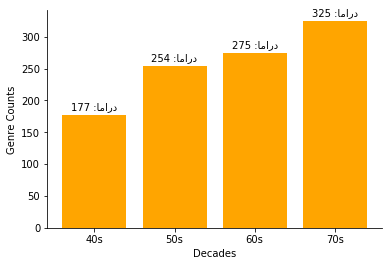

In [234]:
plot_genre_dominations(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)

### Which movie genres had the least existence per decade?

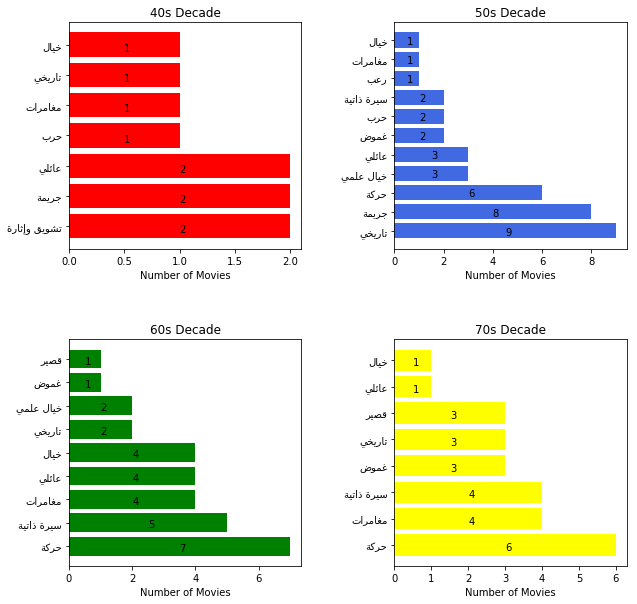

In [277]:
genre_count_40s, genre_count_50s, genre_count_60s, genre_count_70s =\
            get_genres_counts(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)
plot_least_existing_genres(genre_count_40s, genre_count_50s,\
                           genre_count_60s, genre_count_70s)

### Which is the highest rated film in each  decade?

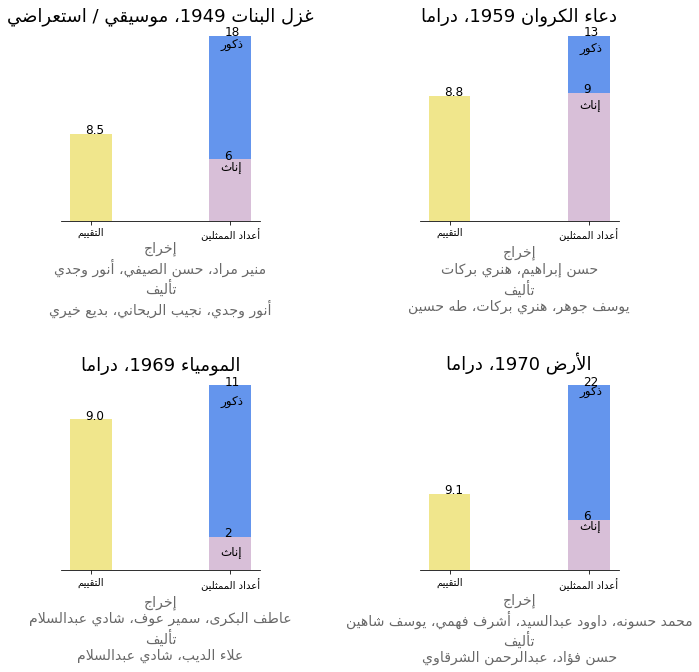

In [254]:
highest_rated_40s, highest_rated_50s,\
    highest_rated_60s, highest_rated_70s \
        = get_highest_rates(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)

plot_highest_rates(highest_rated_40s, highest_rated_50s,\
    highest_rated_60s, highest_rated_70s)

### Has the number of actresses increased over the decades?

Text(0.5, 1.0, 'Increase in Male and Female Presence in Movies')

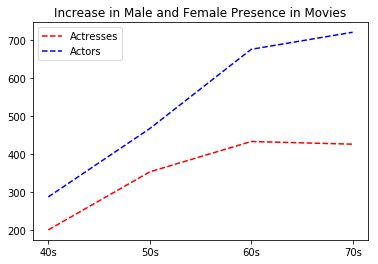

In [255]:
count_actors = get_actors_count(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)
count_actresses = get_actresses_count(movies_40s, movies_50s,\
                                   movies_60s, movies_70s)
figure, axis = plt.subplots()
axis.plot(decades, count_actresses, 'r--', label ='Actresses')
axis.plot(decades, count_actors, 'b--', label = 'Actors')
axis.legend()
axis.set_title('Increase in Male and Female Presence in Movies')

### Which director(s) directed the most movies per decade?

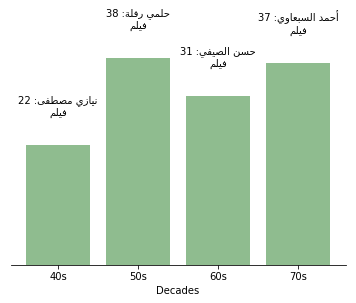

In [256]:
top_directors, top_directors_counts = get_top_directors(movies_40s,\
                                                        movies_50s,\
                                                        movies_60s,\
                                                        movies_70s)
plot_top_directors(top_directors, top_directors_counts)

### What is the average duration of a movie with respect to each genre?

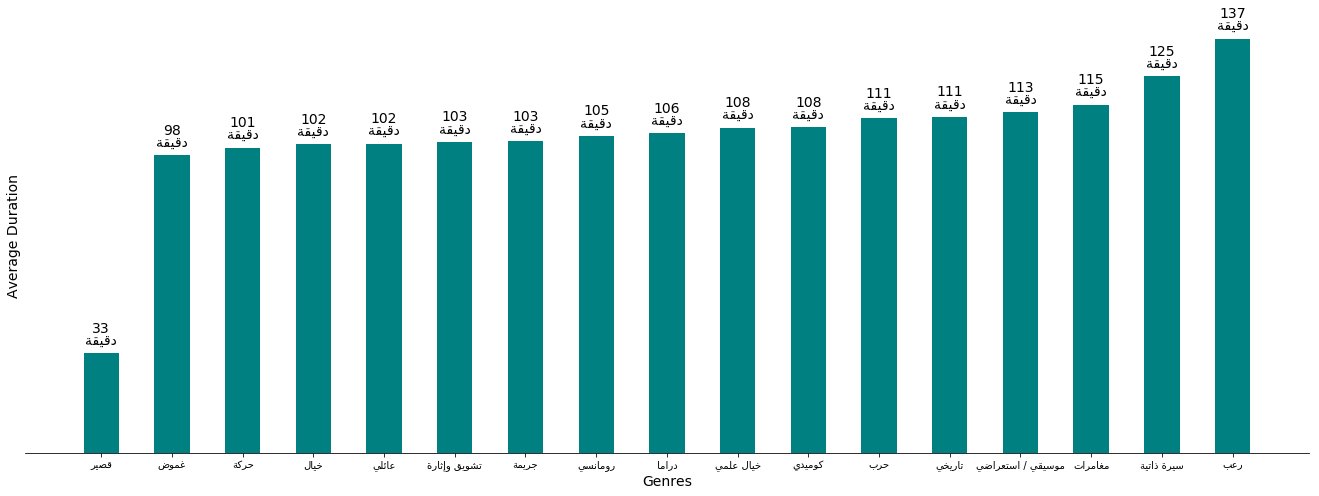

In [259]:
average_duration_per_genre(movies_df)